In [116]:
using BSON: @load
using Flux
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays

Consider the compressed sensing problem of recovering $x\in\mathbb{R}^n$ from noisy measurements of the form

$$y = A x_{0} + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise and $A$ is the compressive sensing matrix. We assume the unknown signal $x$ lives in the range of known generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x_{0} = G(z_0)$ for some $z_0 \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = A_d\sigma(A_{d-1} \cdots \sigma(A_1 z)\cdots),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma(\cdot)$ is the activation function. We
determine the conditions (on $A, G, x_{0}$, \etc) under which it is possible to (approximately) recover $x_{0}$ from noisy linear measurements $y$ by (approximately) solving an optimization problem of the form

$$\argmin_{z \in \mathbb{R}^{k}} \|b - A G(z) \|_{2}. $$

Although this optimzation problem is non-convex, it has been shown that gradient descent and other descent-type alogorithm can provably converge to the global optima. We implement the vanilla gradient descent algorithm below:

In [117]:
function GD_CS(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    _, k = size(Flux.params(G)[1])
    z = randn(k)
    iter = 1
    succ_error = 1
    d(z) = gradient(z -> norm(y - A*G(z))^2, z)[1]

    while iter <= max_iter && succ_error > tolerance
        # d gives the PLUGIn direction
        z -= stepsize * d(z)
        succ_error = norm(stepsize * d(z))
        if iter % out_toggle == 0  
            println("====> In Gradient: Iteration: $iter Successive error: $succ_error")
        end
        iter += 1
    end
    return z
end



GD_CS (generic function with 1 method)

In the next experiment, we consider a one hidden layer network of the form $G(z) = A_2σ(A_1z)$. The inner layer matrix $A_1 \in \mathbb{R}^{n_1\times k}$ has $\mathcal{N}(0,1/n_1)$ entries. For the outer layer matrix $A_2 \in \mathbb{R}^{n_2\times n_1}$ ($n_2 = n$), we take a matrix $A_{21}$ which contains columns randomly subsampled (without replacement) from a $n\times n$ DCT matrix and a random matrix $A_{22}$ which contains $\mathcal{N}(0,1/n_2)$ entries and take its convex combination, i.e. 
$$A_2 = \beta A_{21} + (1-\beta) A_{22}$$
for $\beta \in [0,1]$.

For each $\beta \in [0.7,1]$, we attempt to recover the code vector $z_0$ from measurement of the form $y = A G(z_0)$ where $A \in \mathbb{R}^{m\times n}$ is subsampled DCT matrix (without replacement) by solve the least squares optimzation problem using the gradient descent algorithm. We show the results from 20 trials for each $\beta$ and for all trials, $z_0, A_1, A_{21}$, and $A_{22}$ are fixed. For all experiments, $k = 20, n = 400$, $n_1$ is approximately 100, and $m$ is approximately 160.

In [3]:
#setup a synthetic problem
x_dim = 400
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

# sampling rows of DCT matrix for outer layer
sampling = rand(Bernoulli(100/x_dim), x_dim)
sampling = convert.(Int, sampling)
ndm1 = sum(sampling) #number of neurons n_1
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end

A = F[nnzindex,:]' # subsampled DCT
B = randn(x_dim, ndm1)/sqrt(x_dim) #random matrix thats used in convex combination

W1 = randn(ndm1, 20)/sqrt(ndm1) #random inner layer weight matrix

I(x) = x
z = randn(k) # ground code vector

β_list = .7:.01:1
trials = 20
recovery_error_matrix = zeros(length(β_list))
recon_error_matrix = zeros(length(β_list))
α_list = []

for trial in 1:trials
    recovery_error_list = []
    recon_error_list = []   
    α_list = []
    for β in β_list
        Aint = β*A + (1-β) * B

        #setup the generative network 
        G = Chain(
            Dense(20, ndm1, relu, bias = false; initW =(out,in) -> W1),
            Dense(ndm1, x_dim, I, bias = false; initW =(out,in) -> Aint)
        )

        # subsampling DCT for measurement matrix
        sampling = rand(Bernoulli(.4), x_dim)
        sampling = convert.(Int, sampling)
        m = sum(sampling)
        nnzindex = []
        for i in 1:length(sampling)
            if sampling[i] != 0
                push!(nnzindex, i)
            end
        end
        F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m)

        # measurement vector using subsampled DCT matrix
        y = F_sub*G(z)

        stepsize = .5
        tolerance = 1e-14
        max_iter = 2000
        out_toggle = 2001

        # run gradient descent to solve the least squares problem
        z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
        recov_error = norm(z - real(z_rec))/norm(z)
        recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
        Fn = F  
        α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))

        # save results
        push!(recovery_error_list, recov_error)
        push!(recon_error_list, recon_error)
        push!(α_list, α)

    end
    #save results
    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)


end


I (generic function with 1 method)

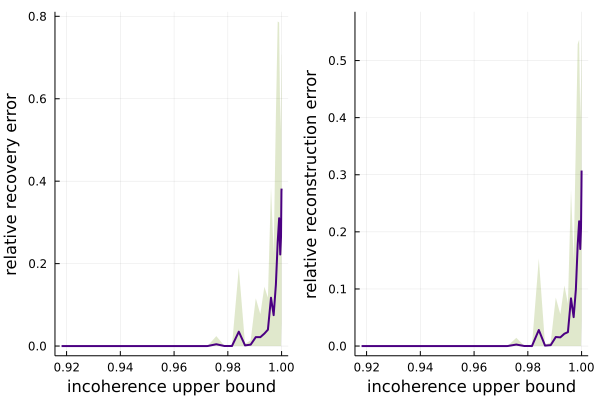

In [38]:
recovery_error_matrix = load("Fourier/recovery_error_matrix_2.jld", "error")
recon_error_matrix = load("Fourier/recon_error_matrix_2.jld", "error")
α_list = load("Fourier/recovery_error_matrix_2.jld", "α_list")

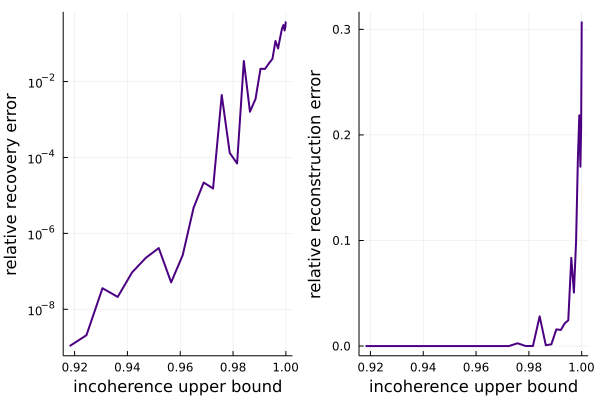

In [42]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recovery_error_matrix[:, 2:end], dims=2)
std_recov = std(recovery_error_matrix[:, 2:end], dims=2)
# plot(α_list, average_recov + std_recov, fillrange = max.(0, average_recov - std_recov), fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
p1 = plot(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false, yaxis =:log )


average_recon = mean(recon_error_matrix[:, 2:end], dims=2)
std_recon = std(recon_error_matrix[:, 2:end], dims=2)
# plot(α_list, average_recon + std_recon, fillrange = max.(0, average_recon - std_recon), fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
p2 = plot(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false )

plot(p1,p2,layout = 2)


The plot above shows a positive dependence of incoherence on recovery of the latent code signal $z_0$. The incoherence shown in figure is with respect to the last layer matrix and $A$ which equals
$$ \sup_{x\in\mathcal{R}(A_2)\cap \mathcal{S}^{n-1}} \|A x\|_\infty = \max_{i \in [n]}\left\{\sup_{u\in\mathbb{R}^{n_1}} \langle a_i, A_2 u\rangle \text{ s.t. } \|A_2u\|_2 = 1 \right\} = \max_{i \in [n]}\left\{\frac{\|A_2^\top a_i\|_2^2}{\|A_2A_2^\top a_i\|_2}\right\}$$
and only provides an upper bound to the incoherence of the GNN w.r.t $A$ given by
$$ \sup_{x\in\mathcal{R}(G)\cap \mathcal{S}^{n-1}}\|A x\|_\infty.$$
Here, $A$ is a unitary matrix and satisfies $A^\top A = AA^\top = I$ 


In [18]:
savefig(p1, "result/Fourier/recov_error_2.pdf")
savefig(p2, "result/Fourier/recon_error_2.pdf")
save("result/Fourier/recovery_error_matrix_2.jld", "error", recovery_error_matrix, "α_list", α_list)
save("result/Fourier/recon_error_matrix_2.jld", "error", recon_error_matrix, "α_list", α_list)


In the next experiment, we use a trained network and use one of its weight matrix to fix the entries of the inner layer matrix $A_1$. This helps reduce the incoherence of the $G(x)$ with respect $A$ (as compared to when $A_1$ contained gaussian entries). The plot generated if from the complete range of $\beta$ from 0 to 1.

In [82]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

epoch_to_load = 3
# Load the model and test set loader
_, _, decoder = load_model("MNIST", epoch_to_load)

#setup a synthetic problem
x_dim = 700
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

sampling = rand(Bernoulli(400/x_dim), x_dim)
sampling = convert.(Int, sampling)
ndm1 = sum(sampling)
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end

A = F[nnzindex,:]'
B = randn(x_dim, ndm1)/sqrt(x_dim)


W1 = Flux.params(decoder)[1][1:ndm1,:]
_, s, _ = svd(W1)
W1 = W1 / s[1]

I(x) = x;


Loading model...Done


In [80]:
z = randn(k)

β_list = 0:.02:1

trials = 10
recovery_error_matrix = zeros(length(β_list))
recon_error_matrix = zeros(length(β_list))
α_list = []

for trial in 1:trials
    recovery_error_list = []
    recon_error_list = []   
    α_list = []

    sampling = rand(Bernoulli(.4), x_dim)
    sampling = convert.(Int, sampling)
    m = sum(sampling)
    nnzindex = []
    for i in 1:length(sampling)
        if sampling[i] != 0
            push!(nnzindex, i)
        end
    end
    F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m)

    for β in β_list
        Aint = β*A + (1-β) * B
        #setup a synthetic problem
        G = Chain(
            Dense(20, ndm1, relu, bias = false; init =(out,in) -> W1),
            Dense(ndm1, x_dim, I, bias = false; init =(out,in) -> Aint)
        )

        y = F_sub*G(z)

        stepsize = .5
        tolerance = 1e-14
        max_iter = 10000
        out_toggle = 300001

        z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
        recov_error = norm(z - real(z_rec))/norm(z)
        recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
        Fn = F  
        α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))

        push!(recovery_error_list, recov_error)
        push!(recon_error_list, recon_error)
        push!(α_list, α)

    end
   recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
   recon_error_matrix = hcat(recon_error_matrix, recon_error_list)

   println("done with trial = $trial\n")

end


done with trial = 1



done with trial = 2



done with trial = 3



done with trial = 4



done with trial = 5



done with trial = 6



done with trial = 7



done with trial = 8



done with trial = 9



done with trial = 10



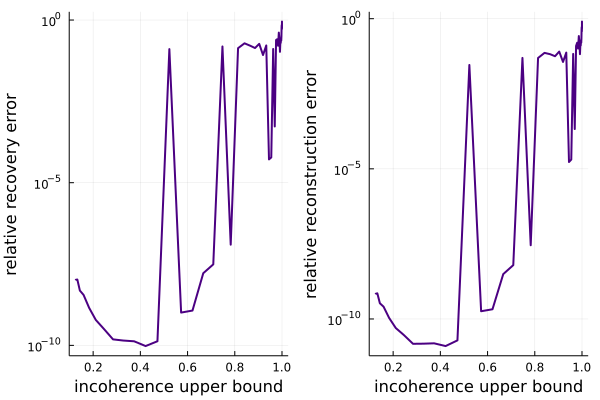

In [81]:
# recovery_error_matrix = load("Fourier/recovery_error_matrix_trained_2.jld", "error")
# recon_error_matrix = load("Fourier/recon_error_matrix_trained_2.jld", "error")
# α_list = load("Fourier/recovery_error_matrix_trained_2.jld", "α_list")


cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recovery_error_matrix[:, 2:end], dims=2)
std_recov = std(recovery_error_matrix[:, 2:end], dims=2)
# plot(α_list, average_recov + std_recov, fillrange = max.(1e-3, average_recov - std_recov), fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
p1 = plot(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false, yaxis =:log)


average_recon = mean(recon_error_matrix[:, 2:end], dims=2)
std_recon = std(recon_error_matrix[:, 2:end], dims=2)
# plot(α_list, average_recon + std_recon, fillrange = max.(0, average_recon - std_recon), fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
p2 = plot(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false, yaxis =:log )

plot(p1,p2,layout = 2)


In [79]:
average_recov[30:40]

11-element Vector{Float64}:
 0.11862865321407819
 0.08438795984844362
 0.15557687429397707
 0.1338201545080734
 0.17535230354547598
 0.30883926532767725
 0.1368639149034998
 0.2675204112247303
 0.05844246225876114
 0.2781968380007986
 0.12690964744843797

In [72]:
avefig(p1, "Fourier/recov_error_trained_3.pdf")
savefig(p2, "Fourier/recon_error_trained_3.pdf")
save("Fourier/recovery_error_matrix_trained_3.jld", "error", recovery_error_matrix, "α_list", α_list)
save("Fourier/recon_error_matrix_trained_3.jld", "error", recon_error_matrix, "α_list", α_list)


Extra tuning codes

In [200]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

epoch_to_load = 3
# Load the model and test set loader
_, _, decoder = load_model("MNIST", epoch_to_load)

#setup a synthetic problem
x_dim = 400
ndm1 = 100
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

W1 = Flux.params(decoder)[1][1:ndm1,:]
_, s, _ = svd(W1)
W1 = W1 / s[1]

e = zeros(x_dim)
index = rand(1:x_dim)
a = F[index,:]
A = a
for i in 1:ndm1-1
    A = hcat(A, a + randn(x_dim))
end
_, s, _ = svd(A)
A = A/s[1];

b = F' * ones(x_dim)
B = b
for i in 1:ndm1-1
    B = hcat(B, b + .1*randn(x_dim))
end
_, s, _ = svd(B)
B = B/s[1];



# sampling = rand(Bernoulli(300/x_dim), x_dim)
# sampling = convert.(Int, sampling)
# ndm1 = sum(sampling)
# nnzindex = []
# for i in 1:length(sampling)
#     if sampling[i] != 0
#         push!(nnzindex, i)
#     end
# end



W1 = randn(ndm1, k)/sqrt(ndm1)

# A = F[nnzindex,:]'
I(x) = x;


Loading model...Done

In [203]:
sampling = rand(Bernoulli(.4), x_dim)
sampling = convert.(Int, sampling)
m = sum(sampling)
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end
F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m);

β = 1
Aint = β*A + (1-β) * B;

In [218]:


b = F' * ones(x_dim)
B = b
for i in 1:2
    B = hcat(B, b + .001*randn(x_dim))
end
_, s, _ = svd(B)
B = B/s[1];

Aint = B
Q, R = qr(Aint);

Fn = F  
α = 0
QA = Q[:,1:rank(B)]
for i in 1:x_dim
    temp = norm(QA'*Fn[i,:], 2)
    α = max(α, temp)
end
α

0.17839735271525253

In [208]:
rank(Aint)

MethodError: MethodError: no method matching rank(::Vector{Float64})
Closest candidates are:
  rank(!Matched::Number) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/LinearAlgebra/src/generic.jl:1015
  rank(!Matched::CholeskyPivoted) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/LinearAlgebra/src/cholesky.jl:697
  rank(!Matched::FillArrays.Zeros) at ~/.julia/packages/FillArrays/5Arin/src/FillArrays.jl:303
  ...

In [167]:

#setup a synthetic problem
G = Chain(
    Dense(20, ndm1, relu, bias = false; init =(out,in) -> W1),
    Dense(ndm1, x_dim, I, bias = false; init =(out,in) -> Aint)
)

z = randn(20)

y = F_sub*G(z)

stepsize = 2
tolerance = 1e-7
max_iter = 10000
out_toggle = 100001




z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
recov_error = norm(z - real(z_rec))/norm(z)
recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
Fn = F  
println()
println("recov $recov_error, recon $recon_error")
α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))


recov 0.20345215774282954, recon 0.28776844754840586


0.5970598608697869

In [108]:
b = F' * ones(700)
B = b
p = 0.5
N = 700
d = 2*(Binomial(1,p) - .5)
l = 200

for i in 1:ndm1-1
    v = rand(d, N)
    B = hcat(B, b + randn(00))
end

# Q, R = qr(B)
# B = Q[:,1:l]

_, s, _ = svd(B)

B = B/s[1]
println(findmax(sum((F*B)' .* (F*B)', dims = 1) ./ sqrt.(sum((F*B*B')' .* (F*B*B')', dims = 1))), sqrt(l/400))

284×414 Matrix{Float64}:
 -2.22045e-16   1.04083e-16   0.0          …   1.32273e-17  -1.249e-16
  2.77556e-17   1.66533e-16   6.10623e-16      1.30646e-17   3.46945e-17
 -1.9906e-16    1.56996       3.33067e-16      2.05998e-17  -2.25514e-17
 -1.38778e-17   2.22045e-16   1.56996          9.86624e-18  -9.71445e-17
 -1.66533e-16   1.66533e-16   1.66533e-16     -1.78893e-18   3.98986e-17
 -7.63278e-17  -1.52656e-16   1.56125e-17  …   1.51788e-18  -5.9848e-17
 -9.71445e-17  -8.32667e-17  -4.16334e-17     -5.55654e-18   2.94903e-17
  6.93889e-18   2.08167e-17   5.55112e-17     -1.95156e-18   8.23994e-18
  1.73472e-17   6.93889e-18   1.38778e-17      1.32273e-17  -2.84061e-17
  6.93889e-18   1.38778e-17  -6.93889e-18      1.53957e-17  -1.64799e-17
  ⋮                                        ⋱                
  1.24683e-17  -1.43115e-17   2.38524e-18  …   3.81639e-17   3.46945e-17
  2.43945e-18   7.80626e-18   1.13841e-17      2.42861e-17   4.16334e-17
  8.0231e-18    2.29851e-17  -9.32414e-18

In [124]:
grad(p) = gradient(p-> -1* norm(F*Aint*p, Inf),p)[1]

for i in 1:100000
    p = randn(100)
    p = p/norm(Aint*p,2)
    if norm(F*Aint*p, Inf) > α[1]
        println("?")
    end
end


In [10]:
findmax(sum((F*Aint)' .* (F*Aint)', dims = 1) ./ sqrt.(sum((F*Aint*Aint')' .* (F*Aint*Aint')', dims = 1)))

(0.5342603591728047, CartesianIndex(1, 337))

In [24]:
p = 0.5
N = 400
d = 2*(Binomial(1,p) - .5)
v = rand(d, N)

At = F'*v
# At = F' * ones(400)
findmax(sum((F*At)' .* (F*At)', dims = 1) ./ sqrt.(sum((F*At*At')' .* (F*At*At')', dims = 1)))

(0.050000000000000086, CartesianIndex(1, 274))